In [20]:
# Packages
using BenchmarkTools
#
using CSV
using DifferentialEquations
#using DataInterpolations
#using DiffEqParamEstim
using Optim
using BlackBoxOptim
using LinearAlgebra
using Plots; pyplot()
#using Plots.PlotMeasures
using LaTeXStrings
#using NLsolve
;

In [2]:
LW1 = 2.5;

In [3]:
df=CSV.read("realdata.csv")
#load If, It, Twc
df_input = df[70:653, [:Column6, :Column13, :Column11 ]]
df_output = df[70:653, [:Column7, :Column8]]
df_water_temp = df[70:653, [:Column10, :Column9]]
If_s, It_s, Twc_s = df_input[1],df_input[2],df_input[3]
Ts_meas_s, TFe_meas_s = df_output[1], df_output[2]
Tac_s, Tah_s = df_water_temp[1],df_water_temp[2]
# All data are vectors of strings and missing, so converting
# it back to float64
#
# N measurement data are used
N = 584
If,It,Twc,Ts_m,TFe_m =zeros(N),zeros(N),zeros(N),zeros(N),zeros(N)
Tac_m, Tah_m = zeros(N), zeros(N)
for i in range(1,step=1,N)
    If[i]=parse(Float64, If_s[i])
    It[i]=parse(Float64, It_s[i])
    Twc[i]=parse(Float64, Twc_s[i])
    Ts_m[i]=parse(Float64, Ts_meas_s[i])
    TFe_m[i]=parse(Float64, TFe_meas_s[i])
    Tac_m[i]=parse(Float64, Tac_s[i])
    Tah_m[i]=parse(Float64, Tah_s[i])
end
tm = range(0,stop=(584-1));

In [4]:
# Available data of states for defining loss function
data = [Ts_m TFe_m]'

2×584 Adjoint{Float64,Array{Float64,2}}:
 31.4186  32.3701  32.9818  34.4092  …  68.8184  68.8184  68.8184  68.8184
 32.3701  32.3701  32.3701  32.3701     60.3393  60.3393  60.3393  60.3393

In [17]:
# Input functions given from data each at 60 sec
function If_t(t)
    # Iterative value of Ifd from real data
    # taken at 60 seconds
    t=trunc(Int,t/60+1)
    return If[t]
end
function It_t(t)
    # Iterative value of It from real data
    t=trunc(Int,t/60+1)
    return It[t]
end
function Twc_t(t)
    # Iterative value of Twc from real data
    t=trunc(Int,t/60+1)
    return Twc[t]
end
#
time = range(tm[1],tm[end],length=10^3)
@benchmark If_t.(time)

BenchmarkTools.Trial: 
  memory estimate:  31.56 KiB
  allocs estimate:  1496
  --------------
  minimum time:     43.800 μs (0.00% GC)
  median time:      45.000 μs (0.00% GC)
  mean time:        49.018 μs (5.27% GC)
  maximum time:     2.087 ms (97.66% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [6]:
u = (If=If_t, It=It_t, Twc=Twc_t)

(If = If_t, It = It_t, Twc = Twc_t)

In [7]:
# Model 1
function generator(dx,x,p,t,u)
    # unpacking states
    Tr,Ts,TFe = x
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # inputs
    If = u.If(t)
    It = u.It(t)
    Twc = u.Twc(t)
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe = 1.012,4.1813,0.385,0.412 
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    # Matrices
    M1 = diagm(0=>[(Nmr*mr)*chpCu , (Nms*ms)*chpCu , (NmFe*mFe)*chpFe])
    M2 = [-(NUAr2d*UAr2d) 0. 0.; 0. -(NUAs2Fe*UAs2Fe) (NUAs2Fe*UAs2Fe); 0. (NUAs2Fe*UAs2Fe) -(NUAs2Fe*UAs2Fe)-(NUAFe2a*UAFe2a)]
    M3 = [0. (UAr2d) 0.; 0. 0. 0.; 0. 0. (UAFe2a)]
    #
    N1 = [-(Nmda*mda)*chpa (Nmda*mda)*chpa+(NUAr2d*UAr2d) 0.; 0. -(Nmda*mda)*chpa (Nmda*mda)*chpa+(NUAFe2a*UAFe2a); NStw-NSta*exp(-NStd) 0. -NStd]
    N2 = [(NUAr2d*UAr2d) 0. 0.; 0. 0. (NUAFe2a*UAFe2a); 0. 0. 0.]
    #
    v = [1.1*(Rr)*If^2, 3*(Rs)*It^2, (NQdFes*QdFes)]
    w = [Qdfs, 0., NSta*(1-exp(-NStd))*Twc]
    #
    z = N1\(N2*x + w)
    dxdt = M1\(M2*x+M3*z + v)
    dx[1],dx[2],dx[3]=dxdt
end
#
gen = (dx,x,p,t) -> generator(dx,x,p,t,u)
# Parameters
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
#p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
p = fill(1.,14)
# Initial values
x0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 583*60.)
# Defining ODE problem
prob = ODEProblem(gen,x0,tspan,p)
# @benchmark sol = solve(prob, ABM54(), dt=60)
@benchmark solve(prob, Tsit5(), saveat=60)

BenchmarkTools.Trial: 
  memory estimate:  2.09 MiB
  allocs estimate:  37860
  --------------
  minimum time:     1.557 ms (0.00% GC)
  median time:      1.628 ms (0.00% GC)
  mean time:        1.971 ms (15.75% GC)
  maximum time:     5.747 ms (57.95% GC)
  --------------
  samples:          2535
  evals/sample:     1

In [8]:
sol = solve(prob, Tsit5(), saveat=60)
Sol = reduce(hcat,sol.(sol.t));

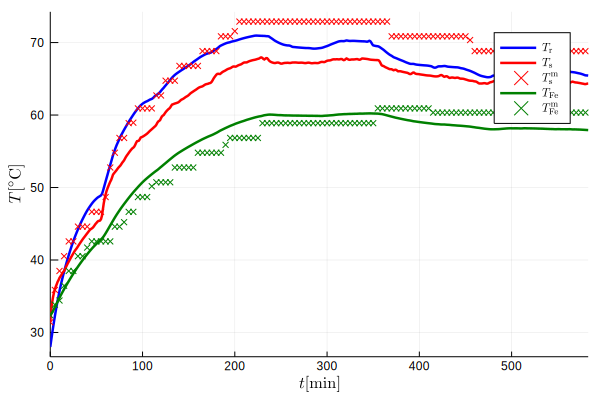

In [9]:
plot(sol.t/60,Sol[1,:],lw=LW1,lc=:blue,label=L"T_\mathrm{r}")
plot!(sol.t/60,Sol[2,:],lw=LW1,lc=:red,label=L"T_\mathrm{s}")
plot!(tm[1:5:end],Ts_m[1:5:end],m=:x,st=:scatter,ms=2,mc=:red,msc=:red,label=L"T_\mathrm{s}^\mathrm{m}")
plot!(sol.t/60,Sol[3,:],lw=LW1,lc=:green,label=L"T_\mathrm{Fe}")
plot!(tm[1:5:end],TFe_m[1:5:end],m=:x,st=:scatter,ms=2,mc=:green,msc=:green,label=L"T_\mathrm{Fe}^\mathrm{m}")
plot!(xlims=(tm[1],tm[end]))
plot!(xlabel=L"t [\mathrm{min}]",ylabel=L"T [{}^\circ \mathrm{C}]")

In [10]:
Data = vcat(Ts_m',TFe_m');
#
function cost(par,idx)
    p = fill(1.,14)
    tspan=(0,583*60.)
    p[idx] .= par
    gen = (dx,x,p,t) -> generator(dx,x,p,t,u)
    prob = ODEProblem(gen,x0,tspan,p)
    sol = solve(prob, Tsit5(), saveat=60, save_idxs = [2,3])
    Sol = reduce(hcat,sol.(sol.t))
    return norm(Data .- Sol,2)./(584*2.0)
end

cost (generic function with 1 method)

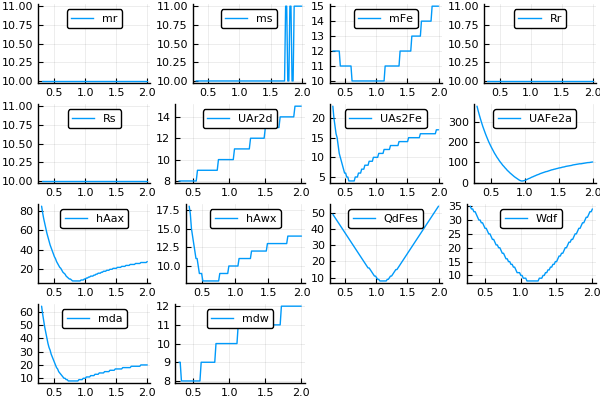

In [145]:
p_name = ["mr","ms","mFe","Rr","Rs","UAr2d","UAs2Fe","UAFe2a","hAax","hAwx","QdFes","Wdf","mda","mdw"]
#
pp = range(0.3,2.,length=100)
loss = (par) -> cost(par,[1])
fg = []
for i in 1:14
    idx = [i]
    loss = (par) -> cost(par,idx)
    y = round.(100*loss.(pp))
    push!(fg,plot(pp,y,label=p_name[i],legend=:top))
end
#push!(fg,plot())
plot(fg...,layout=14)

In [88]:
p_name[[3,7,8,9,10,11,12,13,14]]

9-element Array{String,1}:
 "mFe"   
 "UAs2Fe"
 "UAFe2a"
 "hAax"  
 "hAwx"  
 "QdFes" 
 "Wdf"   
 "mda"   
 "mdw"   

In [89]:
p_name[7]

"UAs2Fe"

In [90]:
# Optimizing parameter 7, i.e., in plot matrix element (3,1)
loss = (par) -> cost(par,[7])
optimize(loss,[0.5],[1.5],[1.0],Fminbox())

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [1.0]
 * Minimizer: [0.7577163938258104]
 * Minimum: 6.411025e-02
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.18e+01 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 500
 * Gradient Calls: 500

*Result above is not ideal... minimizer at 0.76 -- should be ca. 0.6. Instead, use the global optimizer bboptimize from package BlackBoxOptim... which is horribly slow, but reliable*


In [108]:
p_cand = [3,7,8,9,10,11,12,13,14]
p_opt = []
for i in 1:length(p_cand)
    loss = (par) -> cost(par,[p_cand[i]])
    res = bboptimize(loss; SearchRange = (0.3, 2.0), NumDimensions = 1, TraceMode = :silent)
    push!(p_opt,(best_candidate(res)[1],best_fitness(res)))
end

In [113]:
p_opt

9-element Array{Any,1}:
 (0.865273338378857, 0.10002645082418467)  
 (0.5963116609440512, 0.039593845006544406)
 (0.9678316535889422, 0.0770849055616413)  
 (0.8587822762604364, 0.07711299823500943) 
 (0.603655205229849, 0.0771129982146973)   
 (1.110623646078247, 0.078101348845854)    
 (1.1618521654342597, 0.07810377130032002) 
 (0.79654442252706, 0.07723123977046494)   
 (0.42215998149249173, 0.07713461891092786)

In [115]:
p_name[p_cand]

9-element Array{String,1}:
 "mFe"   
 "UAs2Fe"
 "UAFe2a"
 "hAax"  
 "hAwx"  
 "QdFes" 
 "Wdf"   
 "mda"   
 "mdw"   

In [123]:
loss = (par) -> cost(par,p_cand)
res9 = bboptimize(loss; SearchRange = (0.3,2.0), NumDimensions = 9, TraceMode = :silent);

In [125]:
best_candidate(res9)

9-element Array{Float64,1}:
 1.998624028048235 
 0.5933249907202731
 1.3809326529346428
 0.5536904269612861
 1.857770545936128 
 1.9650446015310168
 1.2428066080442641
 1.9694794546254073
 1.0765414183064037

In [127]:
best_fitness(res9)

0.029656690713417224